# 02_Simple-MLP

Based on [Stothers 2018 thesis](https://klab.tch.harvard.edu/publications/PDFs/gk7817.pdf) Dense Network Model Section 2.3

Fully connected (dense) Multi-layer perceptron (MLP):
- fixed layers 1, ..., $m$ and units per layer $L_1, ..., L_m$
- $m=3$
    - 784 units in the input layer
    - 16 units in layer 2
    - 10 units in final classification layer
 
**Packages**
```
pip install keras
pip install tensorflow
```

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import tqdm
import seaborn as sns

In [61]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

## Load Data

In [192]:
batch_size = 2048
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=False,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor()
)

num_val = int(len(training_data) / 6)
val_data, training_data = torch.utils.data.random_split(training_data, [num_val, int(len(training_data) - num_val)])

train_dataloader = DataLoader(training_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [193]:
len(train_dataloader)

25

In [230]:
len(val_dataloader)

5

In [231]:
len(test_dataloader)

5

## Build Model

Following this tutorial: https://medium.com/@artjovianprojects/deep-learning-project-multilayer-perceptron-e34017941918
- Input layer: https://wandb.ai/ayush-thakur/dl-question-bank/reports/Input-Keras-Layer-Explanation-With-Code-Samples--VmlldzoyMDIzMDU

In [13]:
device = "cpu"

In [119]:
nn.Parameter(torch.ones((2, 4), dtype=torch.float))

Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True)

In [156]:
layer = BaseDenseLayer(10, 16)

In [157]:
x = torch.rand((1, 10))
print(x)
new_x = layer.forward(x)
print(new_x.shape)

tensor([[0.3295, 0.1285, 0.5969, 0.8309, 0.3792, 0.6996, 0.2975, 0.2454, 0.0623,
         0.1110]])
torch.Size([1, 16])


In [380]:
class BaseDenseLayer(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim
    ):
        super().__init__()
        self.W = nn.Parameter(nn.init.kaiming_uniform_(torch.empty((input_dim, output_dim), dtype=torch.float)))
        self.b = nn.Parameter(torch.zeros(output_dim, dtype=torch.float))
        self.act = nn.ReLU()
    def forward(self, x):
        return self.act(x @ self.W + self.b)

class PredictionHead(nn.Module):
    """
    No Activation
    """
    def __init__(
        self,
        input_dim: int,
        num_classes: int
    ):
        super().__init__()
        self.W = nn.Parameter(nn.init.kaiming_uniform_(torch.empty((input_dim, num_classes), dtype=torch.float)))
        self.b = nn.Parameter(torch.zeros(num_classes, dtype=torch.float))
        
    def forward(self, x):
        return x @ self.W + self.b
        

class FullNetwork(nn.Module):
    def __init__(
        self,
    ):
        super().__init__()
        self.flatten = nn.Flatten()
        l1 = BaseDenseLayer(28*28, 16)
        l2 = PredictionHead(16, 10)
        self.layers = nn.ModuleList([l1, l2])
        self.trace = []
        
    def forward(self, x):
        x = self.flatten(x)
        for layer in self.layers:
            x = layer(x)
            self.trace.append(x)
        return x
        

In [381]:
model = FullNetwork()
print(model)

FullNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): ModuleList(
    (0): BaseDenseLayer(
      (act): ReLU()
    )
    (1): PredictionHead()
  )
)


## Train Model

In the tutorial, they use `sparse_categorical_crossentropy` since we have sparse labels (10 categories)

In [382]:
def train_loop(dataloader, model, loss_fn, optimizer, val_dataloader=None):
    size = len(dataloader.dataset)
    # set model to training mode
    # generator = torch.Generator().manual_seed(42)
    val_loss = 0

    train_losses = dict()
    val_losses = dict()

    val_loss_fn = nn.CrossEntropyLoss(reduction='sum')
    
    for batch, (X, y) in enumerate(dataloader):
        model.train()
        pred = model(X)
        loss = loss_fn(pred, y)
        train_losses[batch] = loss.item()
        
        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() #reset gradients of model parameters for each batch to avoid double counting

        if batch % 10 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:7f} [{current:>5d}/{size:>5d}]")

            # Validation
            model.eval()
            with torch.no_grad():
                val_loss = 0.
                for val_batch, (X_val, y_val) in enumerate(val_dataloader):
                    pred = model(X_val)
                    val_loss += val_loss_fn(pred, y_val).item()
            val_losses[batch] = val_loss / len(val_dataloader.dataset)
            print(f"Val loss: {val_loss:7f}")

    return train_losses, val_losses

def test_loop(dataloader, model, loss_fn):
    # set to evaluation mode
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad(): # no gradients computed
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>3f}\n")
    return correct, test_loss


In [383]:
model_pth = './data/02.pytorch.model.pth'
model_pth

'./data/02.pytorch.model.pth'

In [384]:
model = FullNetwork()

learning_rate = 1e-2 # how much to update model parameters at each epoch. Speed of learning
epochs = 50 # number of times to iterate over dataset

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # make sure model is the right instance
test_df = pd.DataFrame(index=np.arange(epochs), columns=['test_err', 'test_loss'])
test_df.index.name = 'epoch'
train_losses_epoch = dict()
val_losses_epoch = dict()
for i, t in enumerate(range(epochs)):
    print(f"Epoch {t+1}\n----------------")
    train_losses, val_losses = train_loop(train_dataloader, model, loss_fn, optimizer, val_dataloader)
    train_losses_epoch[i] = train_losses
    val_losses_epoch[i] = val_losses
    
    test_err, test_loss = test_loop(test_dataloader, model, loss_fn)
    test_df.loc[i] = [test_err, test_loss]

print("done!")

torch.save(model.state_dict(), model_pth)

Epoch 1
----------------
loss: 6.663597 [ 2048/50000]
Val loss: 63106.208008
loss: 5.152418 [22528/50000]
Val loss: 50591.173828
loss: 4.385674 [43008/50000]
Val loss: 43827.278809
Test Error 
 Accuracy: 12.5%, Avg loss: 4.201269

Epoch 2
----------------
loss: 4.262953 [ 2048/50000]
Val loss: 41345.017090
loss: 3.759362 [22528/50000]
Val loss: 37374.766113
loss: 3.399887 [43008/50000]
Val loss: 34315.831055
Test Error 
 Accuracy: 15.8%, Avg loss: 3.326109

Epoch 3
----------------
loss: 3.391658 [ 2048/50000]
Val loss: 33048.307617
loss: 3.091268 [22528/50000]
Val loss: 30874.026367
loss: 2.860721 [43008/50000]
Val loss: 29088.101562
Test Error 
 Accuracy: 19.1%, Avg loss: 2.828725

Epoch 4
----------------
loss: 2.891117 [ 2048/50000]
Val loss: 28317.814941
loss: 2.690816 [22528/50000]
Val loss: 26961.496094
loss: 2.525162 [43008/50000]
Val loss: 25808.534668
Test Error 
 Accuracy: 23.2%, Avg loss: 2.512785

Epoch 5
----------------
loss: 2.570558 [ 2048/50000]
Val loss: 25297.084473

In [392]:
torch.save(model.state_dict(), model_pth)

In [385]:
test_df.head()

,test_err,test_loss
epoch,,
0,0.1249,4.201269
1,0.1582,3.326109
2,0.1906,2.828725
3,0.2321,2.512785
4,0.2689,2.294948


In [386]:
model.layers

ModuleList(
  (0): BaseDenseLayer(
    (act): ReLU()
  )
  (1): PredictionHead()
)

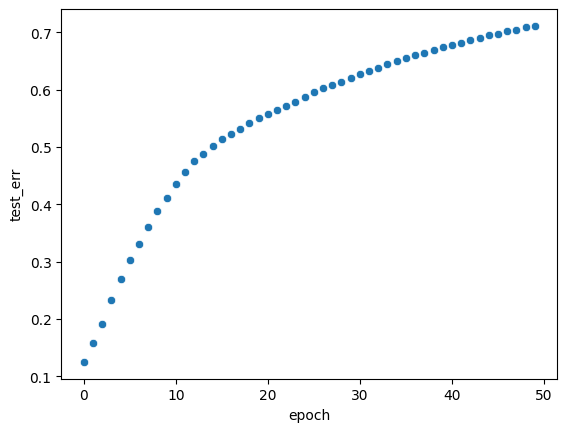

In [387]:
sns.scatterplot(test_df.reset_index(), x='epoch', y='test_err') 
plt.show()

In [388]:
training_losses_df = pd.DataFrame(train_losses_epoch).T
training_losses_df.columns.name = 'batch'
training_losses_df.index.name = 'epoch'

val_losses_df = pd.DataFrame(val_losses_epoch).T
val_losses_df.columns.name = 'batch'
val_losses_df.index.name = 'epoch'

In [389]:
stack_training_losses_df = training_losses_df.stack().reset_index().rename(columns={0: 'loss'})
stack_training_losses_df.index = stack_training_losses_df['epoch'].astype(str) + '-' + stack_training_losses_df['batch'].astype(str)
stack_training_losses_df.index.name = 'index'
stack_val_losses_df = val_losses_df.stack().reset_index().rename(columns={0: 'loss'})
stack_val_losses_df.index = stack_val_losses_df['epoch'].astype(str) + '-' + stack_val_losses_df['batch'].astype(str)
stack_val_losses_df.index.name = 'index'

In [390]:
stack_val_losses_df.head()

,epoch,batch,loss
index,,,
0-0,0,0,6.310621
0-10,0,10,5.059117
0-20,0,20,4.382728
1-0,1,0,4.134502
1-10,1,10,3.737477


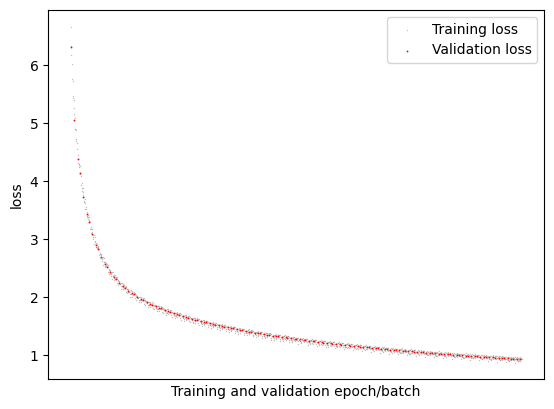

In [391]:
sns.scatterplot(stack_training_losses_df.reset_index(), x='index', y='loss', s=1, label='Training loss', alpha=0.5, c='gray')
sns.scatterplot(stack_val_losses_df.reset_index(), x='index', y='loss', s=2, label='Validation loss', c='red')
plt.xticks([])
plt.xlabel('Training and validation epoch/batch')
plt.show()

**TODO**: 
- Play with learning rate
- Train and test on same dataset
- draw your own digit

## Test Model

In [332]:
loaded_model = torch.load(model_pth)

In [343]:
with torch.no_grad():
    loaded_model.eval() # not training
    ys = []
    pred_ys = []
    for X, y in test_dataloader:
        pred_y = loaded_model(X)
        ys.append(y)
        pred_ys.append(torch.argmax(pred_y, axis=1))

ys = torch.cat(ys)
pred_ys = torch.cat(pred_ys)

In [344]:
ys

tensor([7, 2, 1,  ..., 4, 5, 6])

In [345]:
pred_ys

tensor([7, 2, 1,  ..., 4, 8, 6])

In [346]:
print(f"Accuracy: {metrics.accuracy_score(y_true=ys, y_pred=pred_ys)}")

Accuracy: 0.8627


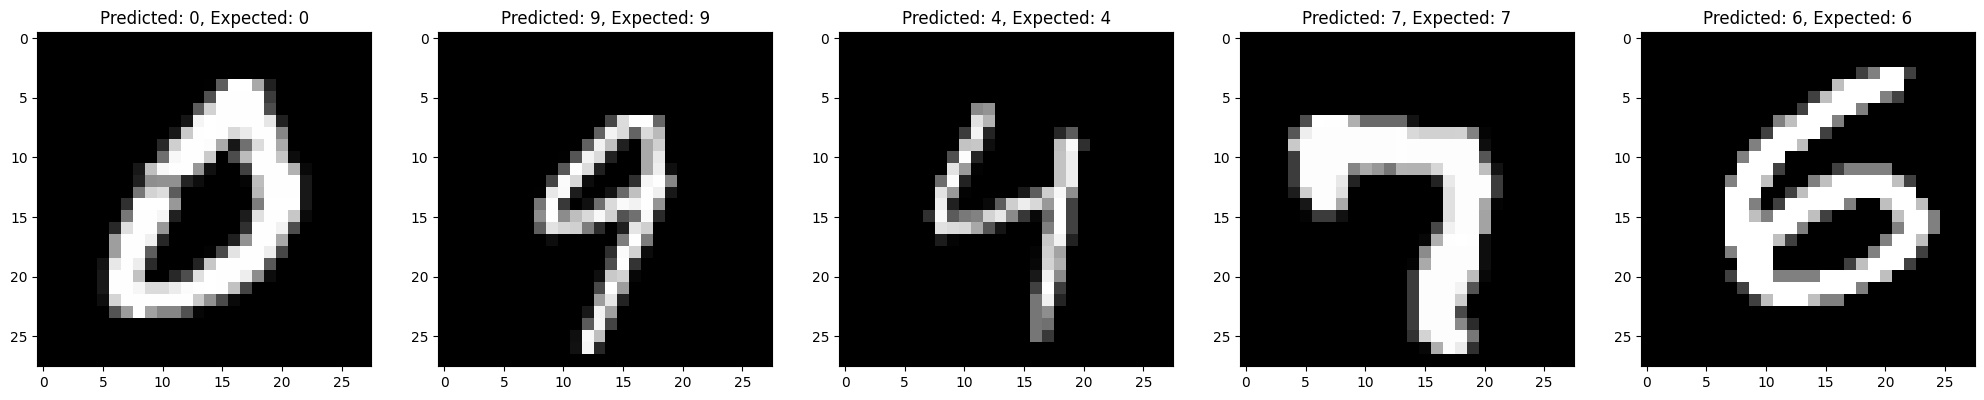

In [359]:
correct_idx = np.where(ys == pred_ys)[0]
display_idx = correct_idx[np.random.randint(len(correct_idx), size=5)]
num_subplots = len(display_idx)
height = 5
fig, axes = plt.subplots(1, num_subplots, figsize=(num_subplots * height, height))
for i, di in enumerate(display_idx):
    axes[i].imshow(test_data.data[di], cmap='gray') # normalized
    axes[i].set_title(f"Predicted: {pred_ys[di]}, Expected: {ys[di]}")
plt.show()

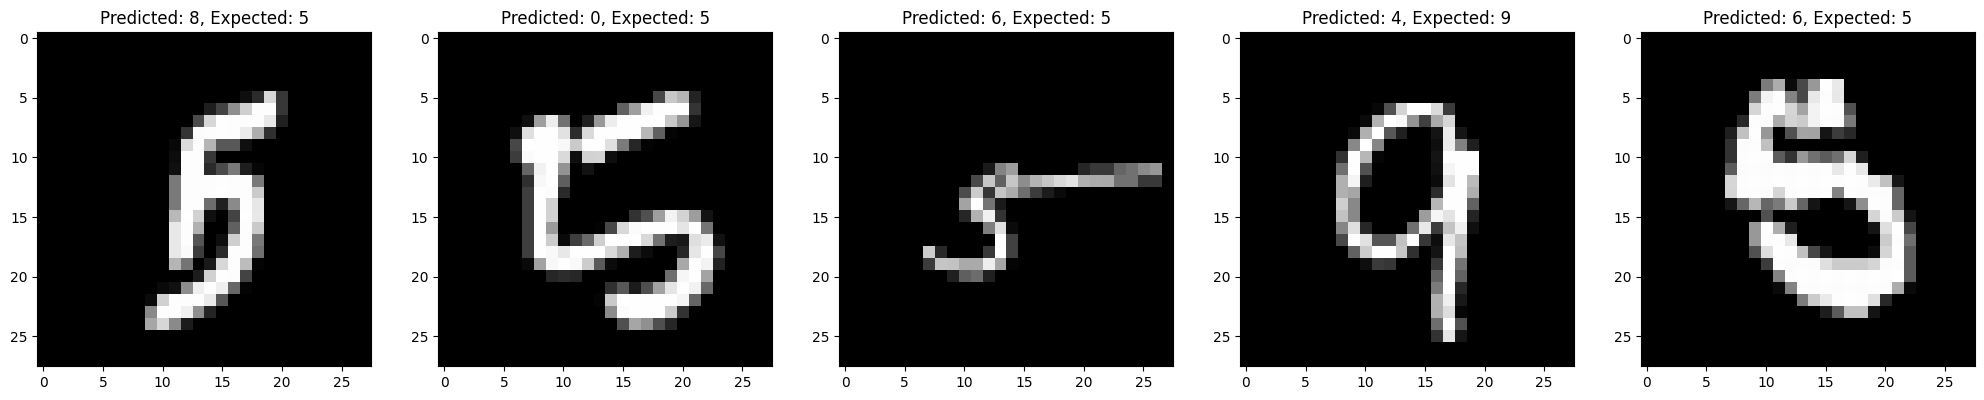

In [360]:
incorrect_idx = np.where(ys != pred_ys)[0]
display_idx = incorrect_idx[np.random.randint(len(incorrect_idx), size=5)]
num_subplots = len(display_idx)
height = 5
fig, axes = plt.subplots(1, num_subplots, figsize=(num_subplots * height, height))
for i, di in enumerate(display_idx):
    axes[i].imshow(test_data.data[di], cmap='gray') # normalized
    axes[i].set_title(f"Predicted: {pred_ys[di]}, Expected: {ys[di]}")
plt.show()

In [361]:
confusion_matrix = metrics.confusion_matrix(y_true=ys, y_pred=pred_ys, labels=np.arange(10))

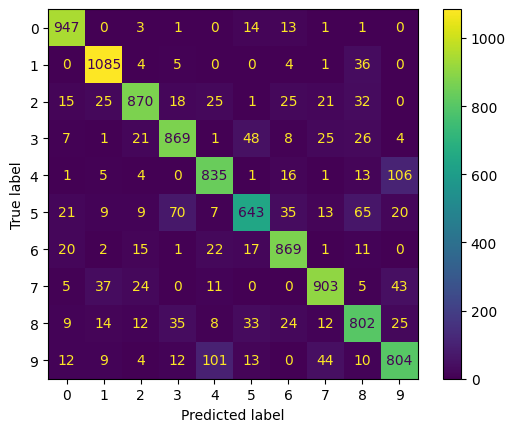

In [362]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=np.arange(10))
disp.plot()
plt.show()